In [3]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mnist

#munge data from mnist
rawX = mnist.train_images().astype(np.float32)
def subsample(X,step=3):
    return np.array([im[0::step,0::step] for im in X])
rawX = subsample(rawX)
rawX = rawX[:,1:9,1:9] #remove row around edges of images (rarely used)

allX = rawX.reshape(60000,np.prod(rawX.shape[1:])) #flatten it
ally = mnist.train_labels()
keep = ally<2
allX = allX[keep,:]
ally = ally[keep]
ally = ally[:,None]
X = allX[0:300,:]
y = ally[0:300,:]
testX = allX[500:600,:]
testy = ally[500:600,:]

# GP Simple Classifier

Here we demonstrate attacking the simple GP classifier

In [2]:
#build model
from GPadversarial import simple
m = simple.build_model(X,y)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s18  0004   1.884938e+02   3.918709e-01 
    01s66  0034   2.133011e+01   7.352433e-11 
Runtime:     01s66
Optimization status: Converged



In [3]:
#compute classification accuracy on test data.
pred, _ = m.predict(testX)
np.mean((pred>0.5)==(testy==1))

1.0

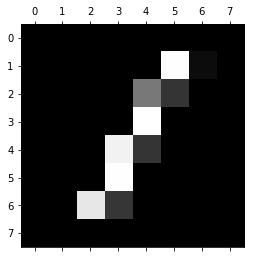

In [4]:
advX = testX[1:2,:].copy() #the initial test point we're going to use...
plt.matshow(advX.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')

In [42]:
N = 64
adv = advX.copy()
for it in range(2):
    adv = adv.repeat(N,0)
    for i in range(N):
        adv[i::N,i]=255

In [43]:
lowest = np.Inf
lowestim = None
for it in range(len(adv)):
    b = adv[it,:][None,:]
    for it in range(2):
        b = b.repeat(N,0)
        for i in range(N):
            b[i::N,i]=255
    preds = m.predict(b)[0]
    minpredi = np.argmin(preds)
    if (preds[minpredi]<lowest):
        lowest = preds[minpredi]
        lowestim = b[minpredi]

[ 0.39626248]


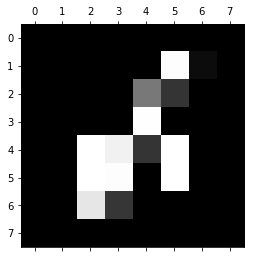

In [44]:
print(lowest)
plt.matshow(lowestim.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')

# GP LVM

In [9]:
#build model
from GPadversarial import lvm
m, clf = lvm.build_model(X,y)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s04  002   1.146396e+07   1.928151e+13 
    00s19  007   2.156860e+06   4.935604e+10 
    01s74  102   9.257820e+04   7.928779e+02 
Runtime:     01s74
Optimization status: Maximum number of f evaluations reached



 /home/mike/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [21]:
m.rbf.lengthscale = 1000 #longer lengthscale better?
m.optimize()

 /home/mike/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1
 /home/mike/GPy/GPy/kern/src/stationary.py:158: RuntimeWarning:overflow encountered in true_divide
 /home/mike/GPy/GPy/kern/src/stationary.py:129: RuntimeWarning:overflow encountered in square
 /home/mike/GPy/GPy/kern/src/stationary.py:130: RuntimeWarning:invalid value encountered in add


In [23]:
m.rbf.lengthscale

index,GPLVM.rbf.lengthscale,constraints,priors
[0],292.89276903,+ve,
[1],701.53234248,+ve,
[2],762.70378271,+ve,
[3],570.20913547,+ve,


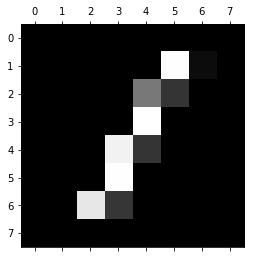

In [24]:
advX = testX[1:2,:].copy() #the initial test point we're going to use...
plt.matshow(advX.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')

In [25]:
N = 64
adv = advX.copy()
for it in range(1):
    adv = adv.repeat(N,0)
    for i in range(N):
        adv[i::N,i]=255

In [27]:
lowest = np.Inf
lowestim = None
for it in range(len(adv)):
    b = adv[it,:][None,:]
    for it in range(1):
        b = b.repeat(N,0)
        for i in range(N):
            b[i::N,i]=255
    preds = lvm.get_pred(m,clf,b)
    minpredi = np.argmin(preds)
    if (preds[minpredi]<lowest):
        lowest = preds[minpredi]
        lowestim = b[minpredi]

[ 12.3789685]


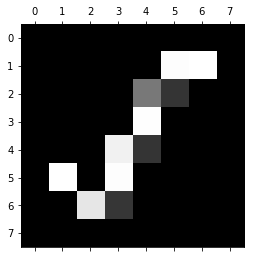

In [28]:
print(lowest)
plt.matshow(lowestim.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')

# GPLVM + GP

In [52]:
#build model
from GPadversarial import lvm_gp
m, m2 = lvm_gp.build_model(X,y)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s11  005   5.757136e+06   1.331732e+12 
    00s17  007   2.808960e+06   1.249163e+11 
    01s86  103   1.015849e+05   2.834107e+02 
Runtime:     01s86
Optimization status: Maximum number of f evaluations reached



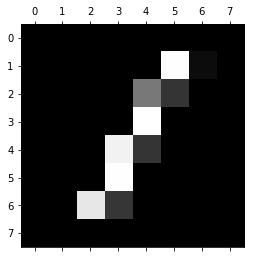

In [53]:
advX = testX[1:2,:].copy() #the initial test point we're going to use...
plt.matshow(advX.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')

In [54]:
preds = lvm_gp.get_pred(m,m2,b[953:954,:])

 /home/mike/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


In [55]:
preds

array([[ 0.78516671]])

In [67]:
N = 64
adv = advX.copy()
for it in range(2):
    adv = adv.repeat(N,0)
    for i in range(N):
        adv[i::N,i]=255

lowest = np.Inf
lowestim = None
for it in range(len(adv)):
    b = adv[it,:][None,:]
    for it in range(2):
        b = b.repeat(N,0)
        for i in range(N):
            b[i::N,i]=255
    preds = lvm_gp.get_pred(m,m2,b)
    minpredi = np.argmin(preds)
    if (preds[minpredi]<lowest):
        lowest = preds[minpredi]
        lowestim = b[minpredi,:]

KeyboardInterrupt: 

In [68]:
lowest

array([ 0.13162026])

In [69]:
lvm_gp.get_pred(m,m2,lowestim[None,:])

array([[ 0.13229362]])

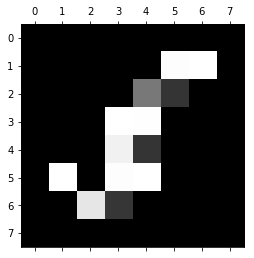

In [70]:
plt.matshow(lowestim.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')

In [71]:
lowestim.shape

(64,)

In [72]:
latent_newX = m.infer_newX(lowestim[None,:])[0]
print(latent_newX)
latent_advX = m.infer_newX(advX)[0]
print(latent_advX)

  index  |  inferenceX.latent_mean  |  constraints  |  priors
  [0 0]  |             13.60135090  |               |        
  [0 1]  |             84.05994657  |               |        
  index  |  inferenceX.latent_mean  |  constraints  |  priors
  [0 0]  |             16.30375720  |               |        
  [0 1]  |             -5.79246386  |               |        


 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


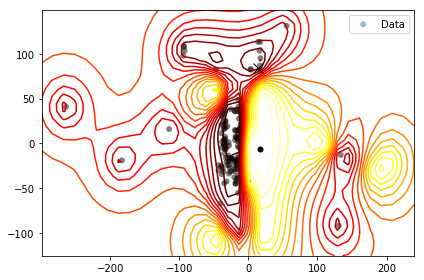

In [73]:
m2.plot()
plt.plot(latent_advX[0,0],latent_advX[0,1],'k.',markersize=10)
plt.plot(latent_newX[0,0],latent_newX[0,1],'kx',markersize=10)

Interestingly this sample appears to have moved a long way in latent space; it demonstrates that points in latent space are not necessarily moved at the same rate in real space.

In [74]:
lvm_gp.get_pred(m,m2,lowestim[None,:])

array([[ 0.13229362]])

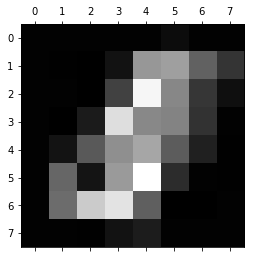

In [75]:
back,_ = m.predict(latent_newX)
plt.matshow(back.reshape(rawX.shape[1],rawX.shape[2]),cmap='gray')